Now that we have learned how to do Transfer Learning, let's try to use it on larger Datasets. We will study the [CalTech101] dataset (http://www.vision.caltech.edu/Image_Datasets/Caltech101/) which contains 40 to 800 images from 101 categories.

Import the classic librairies
Tensorflow 2.0
Numpy
Matplotlib

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

Using tf.keras.utils.get_file(), download and extract the Caltech101 dataset from this link: https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+learning+Images+processing/Transfer+Learning/101_ObjectCategories.tar.gz

In [2]:
import pathlib
data_root_orig = tf.keras.utils.get_file(origin='https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+learning+Images+processing/Transfer+Learning/101_ObjectCategories.tar.gz',
                                         fname='/content/101_ObjectCategories.tar.gz',
                                         untar=True,
                                         cache_subdir="/content")
data_root = pathlib.Path("/content/101_ObjectCategories")
print(data_root)

131740031/131740031 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
/content/101_ObjectCategories


We successfully downloaded the data, however we need to extract the zipped archive to access the image files. We can do so by using the shutil library and it's function unpack_archive to do so.

already done with untar=True

# Preprocessing with ImageDataGenerator

We will now proceed to the preprocessing of our data. The easiest way to do so is using an ImageDataGenerator, that is a very straight forward way to load and preprocess image data for training deep learning models.

Instanciate an ImageDataGenerator with the parameters of your choice, we can adapt them later as we visualize the images and assess the difficulty of the problem.


In [3]:
img_generator = tf.keras.preprocessing.image.ImageDataGenerator(brightness_range=(0.5,1),
                                                                channel_shift_range=0.2,
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                rescale=1./255,
                                                                validation_split=0.3)

Prepare two objects img_generator_flow_train and img_generator_flow_valid thanks to the method flow_from_directory. Why is this method well suited to our usecase? Use a target_size of (224,224) and the rest is up to your appreciation.

In [4]:
img_generator_flow_train = img_generator.flow_from_directory(
    directory='/content/101_ObjectCategories',
    target_size=(224,224),
    batch_size=32,
    shuffle=True,
    subset='training'
)

img_generator_flow_valid = img_generator.flow_from_directory(
    directory='/content/101_ObjectCategories',
    target_size=(224,224),
    batch_size=32,
    shuffle=True,
    subset='validation'
)

Found 6444 images belonging to 102 classes.
Found 2700 images belonging to 102 classes.


Visualize a batch of images coming from the train set. Do you notice anyhting we will have to take into consideration when building the model?

In [5]:
from pathlib import Path

imgs, labels = next(iter(img_generator_flow_train))
for img, label in zip(imgs, labels):
  true_file_path = np.argmax(img_generator_flow_train.labels == tf.argmax(label))
  true_label_name = Path(img_generator_flow_train.filepaths[true_file_path]).parent.name
  print('Label:', true_label_name)
  plt.imshow(img)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Transfer Learning

Import a pretrained model from tensorflow, the solution will use the example of InceptionV3 , but feel free to use different architecture if you would like to get a different point of view. Make sure you use the pretrained weights frome imagenet.

In [6]:
base_model = tf.keras.applications.InceptionV3(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet'
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Set the weights of your imported model as non-trainable

In [7]:
base_model.trainable = False

Create now your complete model by adding the last layer adapted to your situation

In [8]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(102, activation='softmax')
    ])

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 102)                 │         835,686 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,638,470 (86.36 MB)

 Trainable params: 835,686 (3.19 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Compile your model with compile using Adam with a learning rate of 0.001 and the appropriate loss and metrics.

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()]
              )

Train your model and monitor the overfitting using the validation data. Use 20 steps per epochs and 50 epochs in order to monitor the process precisely.

In [11]:
model.fit(img_generator_flow_train, validation_data=img_generator_flow_valid, steps_per_epoch=20, epochs=50)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - categorical_accuracy: 0.1489 - loss: 10.4993 - val_categorical_accuracy: 0.3844 - val_loss: 6.0419
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 810ms/step - categorical_accuracy: 0.4493 - loss: 5.1589 - val_categorical_accuracy: 0.5952 - val_loss: 2.7655
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - categorical_accuracy: 0.6331 - loss: 2.2447 - val_categorical_accuracy: 0.5893 - val_loss: 2.8622
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 855ms/step - categorical_accuracy: 0.6789 - loss: 2.1521 - val_categorical_accuracy: 0.6567 - val_loss: 2.6080
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 824ms/step - categorical_accuracy: 0.7267 - loss: 1.8902 - val_categorical_accuracy: 0.7144 - val_loss: 1.9108
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 831ms/step - categorical_accuracy: 0.7662 - loss: 1.5315 - val_categorical_accuracy: 0.6970 - val_loss: 1.9095
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 972ms/step - categorical_accuracy: 0.8066 - loss: 1.2083

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - categorical_accuracy: 0.8094 - loss: 1.7011 - val_categorical_accuracy: 0.7370 - val_loss: 1.9860
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 60s 786ms/step - categorical_accuracy: 0.7762 - loss: 1.5528 - val_categorical_accuracy: 0.7130 - val_loss: 2.1956
Epoch 13/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 815ms/step - categorical_accuracy: 0.8013 - loss: 1.5123 - val_categorical_accuracy: 0.7474 - val_loss: 2.0245
Epoch 14/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 820ms/step - categorical_accuracy: 0.7834 - loss: 1.4960 - val_categorical_accuracy: 0.7311 - val_loss: 2.0082
Epoch 15/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 883ms/step - categorical_accuracy: 0.8098 - loss: 1.3238 - val_categorical_accuracy: 0.7493 - val_loss: 1.9632
Epoch 16/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - categorical_accuracy: 0.8119 - loss: 1.2836 - val_categorical_accuracy: 0.7541 - val_loss: 1.9546
Epoch 17/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 848ms/step - categorical_accuracy: 0.8331 - loss: 1

In [12]:
model.save('/content/caltechTransferLearningModel.h5')

In [13]:
import json
history_dict = model.history.history
json.dump(history_dict, open('/content/caltechTransferLearningModelHistory.json', 'w'))

In [14]:
tf.keras.utils.get_file("/content/caltechTransferLearningModelHistory.json",
                        origin="https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+learning+Images+processing/Transfer+Learning/caltechTransferLearningModelHistory.json")

'/content/caltechTransferLearningModelHistory.json'

In [15]:
history_dict = json.load(open("/content/caltechTransferLearningModelHistory.json", 'r'))

In [16]:
tf.keras.utils.get_file("/content/caltechTransferLearningModel.h5",
                        origin="https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+learning+Images+processing/Transfer+Learning/caltechTransferLearningModel.h5")

'/content/caltechTransferLearningModel.h5'

In [18]:
model = tf.keras.models.load_model("/content/caltechTransferLearningModel.h5")

Visualize your accuracy on your train and on your test thanks to the attribute history of your model

In [19]:
# Visualise train / Valid Accuracy
plt.plot(model.history.history["categorical_accuracy"], c="r", label="train_accuracy")
plt.plot(model.history.history["val_categorical_accuracy"], c="b", label="test_accuracy")
plt.legend(loc="upper left")
plt.show()

AttributeError: 'Sequential' object has no attribute 'history'

Do the same for your loss

In [20]:
# Visualise train / Valid Loss
plt.plot(model.history.history["loss"], c="r", label="train_loss")
plt.plot(model.history.history["val_loss"], c="b", label="test_loss")
plt.legend(loc="upper left")
plt.show()

AttributeError: 'Sequential' object has no attribute 'history'

# Fine-Tuning

Count the numbers of layers of your pre-trained model

In [21]:
len(base_model.layers)

311

Let about 10% of the layers towards the top in trainable status and freeze the rest. You will have to load the pre-trained model again.

In [22]:
base_model = tf.keras.applications.InceptionV3(input_shape=(224,224,3),
                                               include_top=False,
                                               weights = "imagenet"
                                               )

In [23]:
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 30
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Add some prediction layers to adapt the model to the problem at hand.

In [24]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(102, activation="softmax")
])

In [25]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 2, 2, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 102)                 │         835,686 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,638,470 (86.36 MB)

 Trainable params: 5,991,718 (22.86 MB)

 Non-trainable params: 16,646,752 (63.50 MB)

Compile the model

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

Train the model using 20 steps per epochs and 50 epochs.

In [27]:
model.fit(img_generator_flow_train, validation_data=img_generator_flow_valid, steps_per_epoch=20, epochs=50)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - categorical_accuracy: 0.2880 - loss: 6.1299 - val_categorical_accuracy: 0.6048 - val_loss: 2.5780
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - categorical_accuracy: 0.6311 - loss: 1.9023 - val_categorical_accuracy: 0.6963 - val_loss: 1.8262
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - categorical_accuracy: 0.7549 - loss: 1.1435 - val_categorical_accuracy: 0.7581 - val_loss: 1.3866
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 813ms/step - categorical_accuracy: 0.7947 - loss: 0.7881 - val_categorical_accuracy: 0.7859 - val_loss: 1.1546
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 955ms/step - categorical_accuracy: 0.8235 - loss: 0.7224 - val_categorical_accuracy: 0.7826 - val_loss: 1.0733
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - categorical_accuracy: 0.8749 - loss: 0.5272 - val_categorical_accuracy: 0.7863 - val_loss: 1.0630
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - categorical_accuracy: 0.8741 - loss: 0.555

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 641ms/step - categorical_accuracy: 0.8914 - loss: 0.5308 - val_categorical_accuracy: 0.8415 - val_loss: 0.7295
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - categorical_accuracy: 0.9051 - loss: 0.4203 - val_categorical_accuracy: 0.8252 - val_loss: 0.9013
Epoch 13/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - categorical_accuracy: 0.9055 - loss: 0.4389 - val_categorical_accuracy: 0.8374 - val_loss: 0.7534
Epoch 14/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 861ms/step - categorical_accuracy: 0.9068 - loss: 0.3984 - val_categorical_accuracy: 0.8337 - val_loss: 0.7456
Epoch 15/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 878ms/step - categorical_accuracy: 0.9126 - loss: 0.4406 - val_categorical_accuracy: 0.8356 - val_loss: 0.7200
Epoch 16/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 800ms/step - categorical_accuracy: 0.8893 - loss: 0.4306 - val_categorical_accuracy: 0.8385 - val_loss: 0.7299
Epoch 17/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 808ms/step - categorical_accuracy: 0.9081 - loss: 0

In [28]:
model.save("/content/caltechFineTuningModel.h5")

In [29]:
# Get the dictionary containing each metric and the loss for each epoch
history_dict = model.history.history
# Save it under the form of a json file
json.dump(history_dict, open("/content/caltechFineTuningModelHistory.json", 'w'))

In [30]:
tf.keras.utils.get_file("/content/caltechFineTuningModelHistory.json",
                        origin="https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+learning+Images+processing/Transfer+Learning/caltechFineTuningModelHistory.json")

'/content/caltechFineTuningModelHistory.json'

In [31]:
history_dict = json.load(open("/content/caltechFineTuningModelHistory.json", 'r'))

In [32]:
tf.keras.utils.get_file("/content/caltechFineTuningModel.h5",
                        origin="https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+learning+Images+processing/Transfer+Learning/caltechFineTuningModel.h5")

'/content/caltechFineTuningModel.h5'

In [33]:
model = tf.keras.models.load_model("/content/caltechFineTuningModel.h5")

Visualize your accuracy on your train and on your test

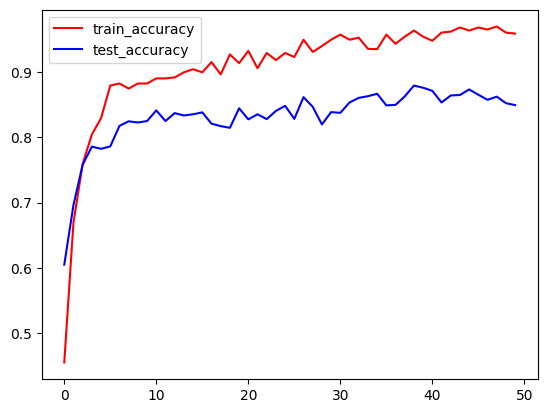

In [34]:
# Visualise train / Valid Accuracy
plt.plot(history_dict["categorical_accuracy"], c="r", label="train_accuracy")
plt.plot(history_dict["val_categorical_accuracy"], c="b", label="test_accuracy")
plt.legend(loc="upper left")
plt.show()

Do the same for your loss

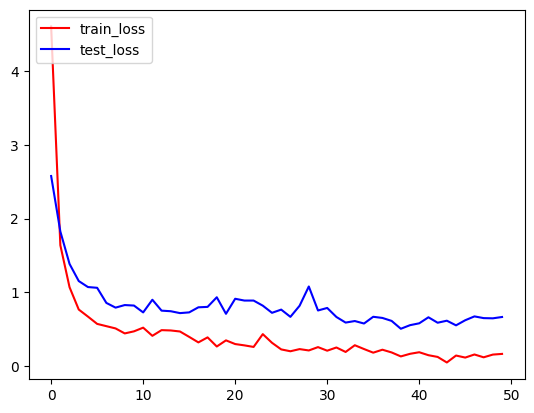

In [35]:
# Visualise train / Valid Loss
plt.plot(history_dict["loss"], c="r", label="train_loss")
plt.plot(history_dict["val_loss"], c="b", label="test_loss")
plt.legend(loc="upper left")
plt.show()

# Interpretation with Grad Cam

Create an object imgs and an object labels containing a batch of validation images and validation labels.

In [36]:
imgs, labels = next(iter(img_generator_flow_valid))

Get the name of the last convolution layer of the pretrained model and the prediction layers and store them in two variables called respectively last_conv_layer_name, and classifier_layer_names.

In [37]:
for layer in model.layers:
  print(layer.name)

inception_v3
max_pooling2d_9
flatten_1
dense_1


In [38]:
base_model = model.layers[0]

In [39]:
tf.keras.utils.plot_model(base_model, show_shapes=True, show_layer_names=True)

InvocationException: Program terminated with status: -6. stderr follows: failed at node 19164[1]
dot: maze.c:313: chkSgraph: Assertion `np->cells[1]' failed.


In [40]:
for layer in base_model.layers:
  print(layer.name)

input_layer_2
conv2d_94
batch_normalization_94
activation_94
conv2d_95
batch_normalization_95
activation_95
conv2d_96
batch_normalization_96
activation_96
max_pooling2d_5
conv2d_97
batch_normalization_97
activation_97
conv2d_98
batch_normalization_98
activation_98
max_pooling2d_6
conv2d_102
batch_normalization_102
activation_102
conv2d_100
conv2d_103
batch_normalization_100
batch_normalization_103
activation_100
activation_103
average_pooling2d_9
conv2d_99
conv2d_101
conv2d_104
conv2d_105
batch_normalization_99
batch_normalization_101
batch_normalization_104
batch_normalization_105
activation_99
activation_101
activation_104
activation_105
mixed0
conv2d_109
batch_normalization_109
activation_109
conv2d_107
conv2d_110
batch_normalization_107
batch_normalization_110
activation_107
activation_110
average_pooling2d_10
conv2d_106
conv2d_108
conv2d_111
conv2d_112
batch_normalization_106
batch_normalization_108
batch_normalization_111
batch_normalization_112
activation_106
activation_108
acti

In [41]:
for layer in model.layers:
  print(layer.name)

inception_v3
max_pooling2d_9
flatten_1
dense_1


In [42]:
last_conv_layer_name = "mixed10"
classifier_layer_names = [layer.name for layer in model.layers][1:]

Run the following command, these functions will help you produce the grad cam

In [43]:
# We start by setting up the dependencies we will use

import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [44]:
# The Grad-CAM algorithm
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, base_model, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = base_model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(base_model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

Create a preds object containing the predicitons from your model on the batch of validation images.

Then create a pred_labels object containing the top class predicted for each image in that batch. (You can use the tf.argmax function for this)

In [45]:
# Print what the top predicted class is
preds = model.predict(imgs)
pred_labels = tf.argmax(preds, axis = -1)

print("Prediction output:", preds)

print("Predicted label:", pred_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Prediction output: [[3.02303825e-02 1.27680090e-04 4.17605916e-05 ... 1.53742076e-05
  4.96742468e-05 2.82160890e-08]
 [4.07602498e-03 1.35199516e-04 1.73474837e-04 ... 1.29360578e-05
  1.28858883e-04 1.66438568e-07]
 [1.13131262e-06 1.13491325e-04 2.53670379e-07 ... 6.49940404e-08
  2.16818285e-06 7.64729426e-12]
 ...
 [3.86701237e-14 2.30734638e-14 2.65570901e-14 ... 1.56830477e-18
  5.57440921e-13 1.07273774e-21]
 [7.02562453e-11 2.76906196e-08 1.00000000e+00 ... 1.62497793e-12
  1.10866893e-09 4.11356839e-16]
 [1.96230631e-05 9.10740482e-07 4.52335280e-06 ... 3.07632547e-07
  3.48426352e-06 3.79306968e-08]]
Predicted label: tf.Tensor(
[96 77 88  6 89 14 44 52  4 48  0 56  2 94 99  4 54 13 56  0 28 36 67  1
 59 30  4 54 24  6  2 56], shape=(32,), dtype=int64)


For all the images in the validation batch use the make_gradcam_heatmap to create a grad cam heatmap and store them all in a list. Then display the first heatmap.

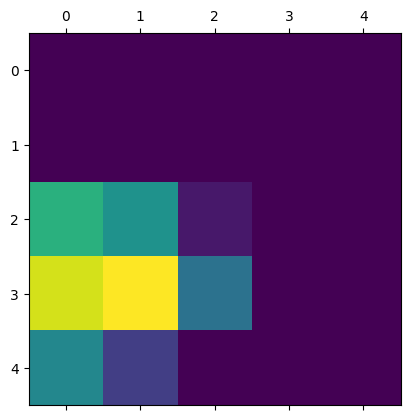

In [46]:
# Generate class activation heatmap
heatmaps = []

for img in imgs:
  heatmap = make_gradcam_heatmap(
    tf.expand_dims(img,axis=0),base_model, model, last_conv_layer_name, classifier_layer_names
  )
  heatmaps.append(heatmap)


# Display heatmap
plt.matshow(heatmaps[0])
plt.show()

Loop over each image, predicted label and heatmap in order to display the images with the superimposed grad cam heatmap and the corresponding predicted label. Do they match the true label? What happens to the grad cam for wrong predictions? Are there any grad cams that seem surprising to you?

Predicted label: water_lilly
True label: lotus


<ipython-input-47-5005e65fcdad>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


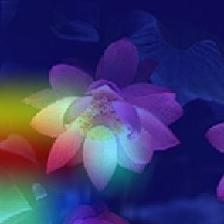

Predicted label: rhino
True label: rhino


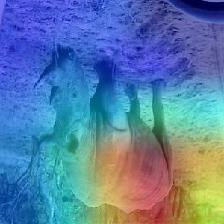

Predicted label: stegosaurus
True label: elephant


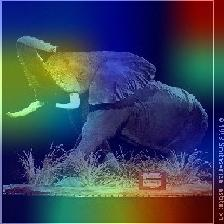

Predicted label: airplanes
True label: airplanes


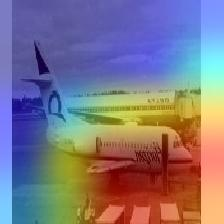

Predicted label: stop_sign
True label: stop_sign


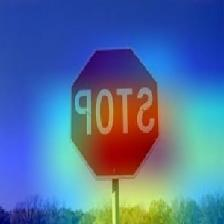

Predicted label: brain
True label: brain


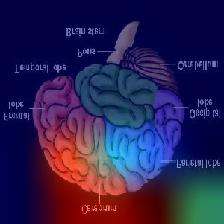

Predicted label: garfield
True label: garfield


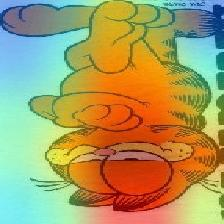

Predicted label: ibis
True label: ibis


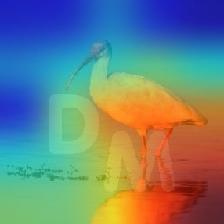

Predicted label: Motorbikes
True label: Motorbikes


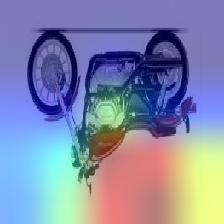

Predicted label: hawksbill
True label: hawksbill


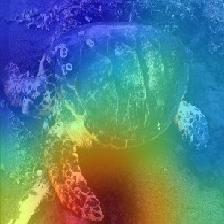

Predicted label: BACKGROUND_Google
True label: octopus


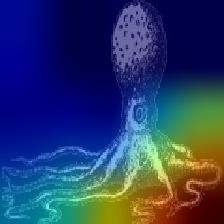

Predicted label: ketch
True label: ketch


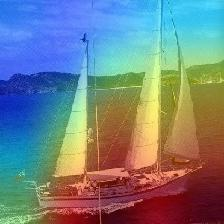

Predicted label: Faces_easy
True label: Faces_easy


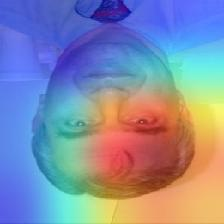

Predicted label: umbrella
True label: umbrella


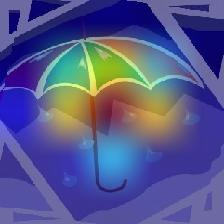

Predicted label: windsor_chair
True label: windsor_chair


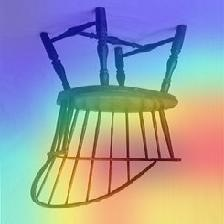

Predicted label: Motorbikes
True label: wheelchair


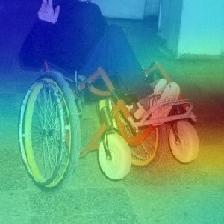

Predicted label: joshua_tree
True label: joshua_tree


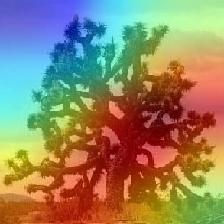

Predicted label: bonsai
True label: bonsai


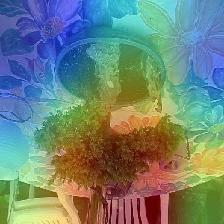

Predicted label: ketch
True label: ketch


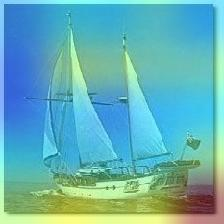

Predicted label: BACKGROUND_Google
True label: soccer_ball


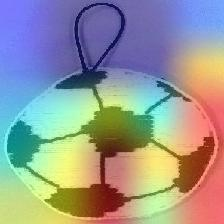

Predicted label: crayfish
True label: crayfish


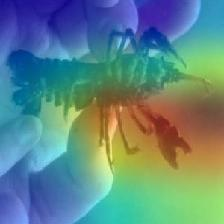

Predicted label: electric_guitar
True label: electric_guitar


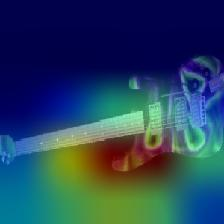

Predicted label: nautilus
True label: nautilus


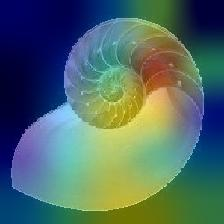

Predicted label: Faces
True label: Faces


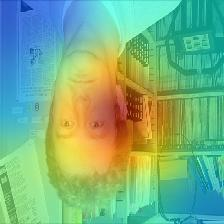

Predicted label: llama
True label: llama


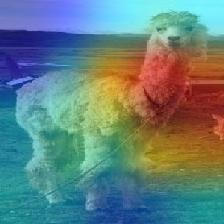

Predicted label: crocodile_head
True label: crocodile_head


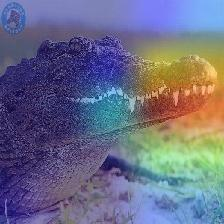

Predicted label: Motorbikes
True label: Motorbikes


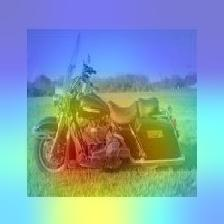

Predicted label: joshua_tree
True label: joshua_tree


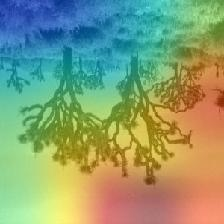

Predicted label: chandelier
True label: chandelier


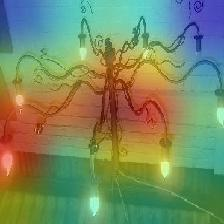

Predicted label: airplanes
True label: airplanes


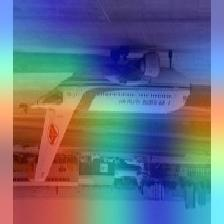

Predicted label: Faces_easy
True label: Faces_easy


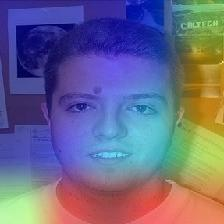

Predicted label: ketch
True label: ketch


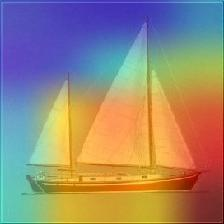

In [47]:
for img, pred_label, true_label, heatmap in zip(imgs, pred_labels, labels, heatmaps):
  # We rescale heatmap to a range 0-255
  heatmap = np.uint8(255 * heatmap)

  # We use jet colormap to colorize heatmap
  jet = cm.get_cmap("jet")

  # We use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  # We create an image with RGB colorized heatmap
  jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

  # Superimpose the heatmap on original image
  superimposed_img = jet_heatmap * 0.003 + img
  superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

  # Save the superimposed image
  save_path = "saved_img.jpg"
  superimposed_img.save(save_path)

  # Display Grad CAM
  pred_file_path = np.argmax(img_generator_flow_valid.labels == pred_label)
  pred_label_name = Path(img_generator_flow_valid.filepaths[pred_file_path]).parent.name

  true_file_path = np.argmax(img_generator_flow_valid.labels == tf.argmax(true_label))
  true_label_name = Path(img_generator_flow_valid.filepaths[true_file_path]).parent.name

  print("Predicted label:",pred_label_name)
  print("True label:", true_label_name)

  display(Image(save_path))